# Data Preprocessing and Experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

#### Book Recommender Dataset

In [2]:
# book recommender
rating = pd.read_csv('data/books/ratings_enc.csv').drop('Unnamed: 0', axis=1)

In [3]:
# user profile data
user = pd.read_csv('data/books/users.csv')#.drop('Unnamed: 0', axis=1)

# encode
encoder = LabelEncoder()
for col in user.columns:
    user['{}'.format(col)] = encoder.fit_transform(user['{}'.format(col)])
    print(user['{}'.format(col)].nunique() == user['{}'.format(col)].max() + 1)

# rename ID column
user.rename(columns={'User-ID':'user_id'}, inplace=True)

# save encoded version
user.to_csv('data/books/users_enc.csv', index=False)
user.head()

True
True
True


,user_id,Location,Age
0,0,36772,165
1,1,48830,18
2,2,33483,165
3,3,40562,17
4,4,16902,165


In [32]:
# item profile data
item = pd.read_csv('data/books/books.csv', low_memory=False)
item = item[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]

# # encode
# encoder = LabelEncoder()
# for col in item.columns:
#     # mode = item['{}'.format(col)].mode()
#     item['{}'.format(col)] = encoder.fit_transform(item['{}'.format(col)].astype(str))
#     # did it work?
#     print(item['{}'.format(col)].nunique() == item['{}'.format(col)].max() + 1)

# # rename ID column
# item.rename(columns={'ISBN':'item_id'}, inplace=True)

# # save
# item.to_csv('data/books/books_enc.csv', index=False)
item.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [5]:
rating.head()

,user_id,item_id,ratings,time_bucket
0,276725,57378,0,0
1,276726,29846,1,0
2,276727,107717,0,0
3,276729,127615,0,0
4,276729,127649,1,0


# Bayesian Clustering with BayesMatch

In [2]:
user = pd.read_csv('data/books/users_enc.csv')
item = pd.read_csv('data/books/books_enc.csv')
rating = pd.read_csv('data/books/ratings_enc.csv')

In [54]:
# create synthetic data
from scipy import stats

# three clusters
n_clusters = 5
alpha = np.ones(n_clusters)
seeds = [1, 2]
theta_u, theta_v = [stats.dirichlet(alpha, seed=seeds[i]).rvs() for i in range(2)]

vocab_sizes = [10, 12, 13, 5, 7]
n_vocabs = len(vocab_sizes)

# sample distriubtion over ontology vocabs within clusters
seeds = np.arange(n_vocabs)
beta_u = [np.ones(vocab_sizes[i]) for i in range(n_vocabs)]
phi_u = [stats.dirichlet(beta_u[i], seed=seeds[i]).rvs(size=n_clusters) for i in range(n_vocabs)]

# phi[i] shape is n_clusters, vocab_sizes[i]
# sample cluster assignments
k_u = stats.multinomial(1, theta_u[0]).rvs().argmax()
k_v = stats.multinomial(1, theta_v[0]).rvs().argmax()

# sample features from phi 
phi_u[k_u]


array([[8.93657286e-02, 2.11011675e-01, 1.89430372e-05, 5.96227837e-02,
        2.62843684e-02, 1.60452263e-02, 3.41352580e-02, 7.02160069e-02,
        8.37094997e-02, 1.28177782e-01, 8.99840502e-02, 1.91428679e-01],
       [1.93513582e-02, 1.78069108e-01, 2.34946485e-03, 9.39189756e-02,
        4.56947093e-02, 6.92079727e-02, 1.27985312e-02, 1.86786438e-02,
        1.36482968e-01, 2.91908430e-01, 3.18149601e-02, 9.97248780e-02],
       [1.62111493e-01, 1.74474770e-01, 6.89193384e-03, 3.08912536e-03,
        1.44326045e-02, 1.63219265e-01, 8.02760581e-03, 4.23876860e-02,
        2.45612417e-01, 5.90702635e-02, 9.12873218e-02, 2.93955138e-02],
       [7.44972656e-02, 1.15573999e-01, 1.18542037e-03, 8.90705333e-02,
        2.88835547e-01, 8.85639326e-02, 2.11374804e-02, 1.00011106e-01,
        6.99730141e-03, 3.81500126e-02, 1.53653527e-01, 2.23238751e-02],
       [5.64000818e-02, 2.31500493e-02, 3.25025848e-03, 1.88764045e-01,
        3.95186226e-02, 5.12924141e-02, 1.12419609e-01, 9.11

In [3]:
from BayesMatch import BayesMatch

n = 1000
n_clusters = 2
match = BayesMatch(
        u_data=user.drop('user_id', axis=1).head(n),
        v_data=item.drop('item_id', axis=1).head(n),
        n_common=0,
        n_clusters=n_clusters,
        burn_in=0,
        n_samples=10,
        eval_every=100
    )

match.fit()

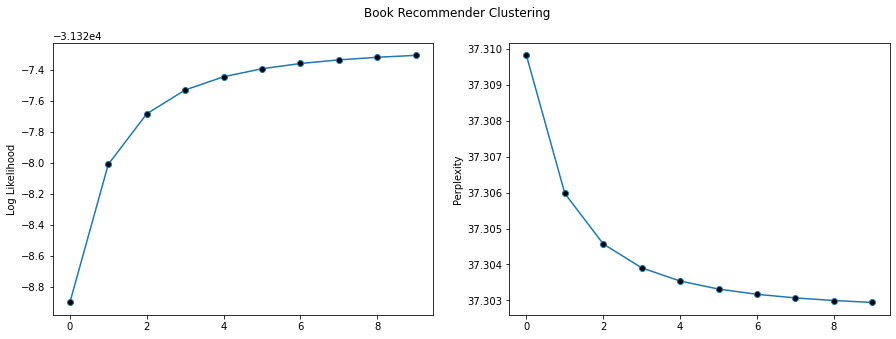

In [4]:
# plot results
burn_in = match.burn_in

# figure
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# plot data
ax[0].plot(match.log_likelihood_trace[burn_in:], marker='o', markerfacecolor='black')
ax[1].plot(match.perplexity_trace[burn_in:], marker='o', markerfacecolor='black')

# labels
plt.suptitle('Book Recommender Clustering')
ax[0].set_ylabel('Log Likelihood')
ax[1].set_ylabel('Perplexity')

# show
plt.show()

Plot Parameter Traces

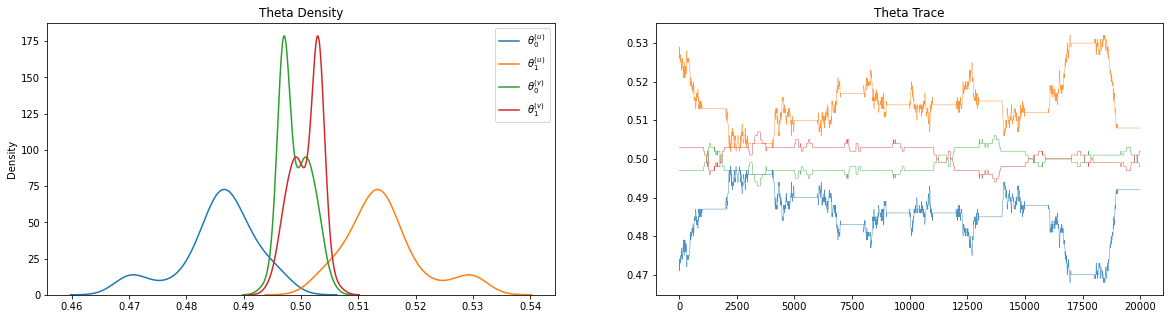

In [5]:
# make figure
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# plot user, item theta
burn_in = match.burn_in
u_theta = [x/sum(x) for x in match.u_theta_trace]
v_theta = [x/sum(x) for x in match.v_theta_trace]

for i, trace in enumerate([u_theta, v_theta]):
    for i in range(n_clusters):
        theta_norm = [x[i] for x in trace[burn_in:]]
        sns.kdeplot(theta_norm, bw_adjust=3, ax=ax[0])

    ax[0].set_title('Theta Density')

    ax[1].plot(trace, lw=0.5, alpha=0.8)
    ax[1].set_title('Theta Trace')

# add legend
legend = []
t = ['{(u)}', '{(v)}']
for l in t:
    legend += ['$\\theta_{}^{}$'.format(i, l) for i in range(n_clusters)]
ax[0].legend(legend)

plt.show()

In [10]:
# features by clusters
# u_trace = [x/sum(x) for x in match.phi_u_trace[x][t]]
# v_trace = [x/sum(x) for x in match.phi_v_trace]
# trace = [u_trace, v_trace]

# view: user 0, item 1
# x: feature index
# t: timestep
view = 0
x = 0  # feature id
t = 0  # timestep
cluster_id = 0

def n_timesteps(x):
    """
    ;param x: feature id
    Return: number of timesteps for feature x
    """
    return len(match.phi_u_trace[x])

# cluster_id x ontology_id
def get_phi(x, t):
    # x: feature id
    # k: cluster id
    # t: timestep
    return match.phi_u_trace[x][t]#[k, :]

def get_phi_norm(x, t):
    """
    ;param x: feature id
    ;param t: timestep
    return: normalized phi
    """
    return get_phi(x, t)/get_phi(x, t).sum(axis=0)

def get_trace(x, v, k):
    """
    ;param x: feature id
    ;param v: value of feature x
    ;param k: cluster id
    return: trace for feature x=v in k
    """
    return [get_phi_norm(x, t)[:, v] for t in range(n_timesteps(x))]

def plot_trace(x, v, k, ax):
    """
    makes trace plot
    ;param x: feature id
    ;param v: value of feature x
    ;param k: cluster id
    ;param fig: matplotlib figure
    """
    trace = get_trace(x, v, k)
    sns.kdeplot([trace[i][k] for i in range(len(trace))], bw_adjust=3, warn_singular=False, ax=ax[0])
    ax[1].plot(trace)

def get_legend():
    return ['Cluster {}'.format(i) for i in range(match.n_clusters)]

def build_figure(x, v, ax):
    # make figure
    for k in range(match.n_clusters):
        plot_trace(x, v, k, ax)
    # add labels
    ax[0].set_title('$\Phi_k$ Density, $x$ = {}, $\\nu$ = {}'.format(k, v))
    ax[0].legend(get_legend())
    plt.show()

def plot_feature_trace(x):
    """
    build and stack plots for onotology of feature x for each cluster
    ;param x: feature id
    """
    d = match.v_users[x]
    fig, ax = plt.subplots(1, 2, figsize=(20, 2.5))
    for v in range(d):
        build_figure(x, v, ax)

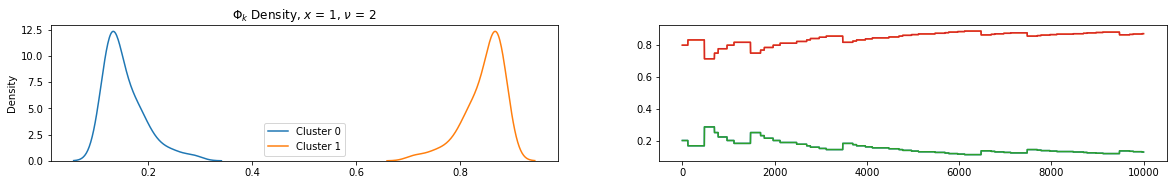

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 2.5))
build_figure(1, 2, ax)

In [31]:
x = 0
k = 0
v = 2

def credible_int(x, v, k):
    trace = get_trace(x, v, k)
    trace_k = [trace[i][k] for i in range(len(trace))]
    
    # compute upper, lower, mean credible interval
    lower = np.percentile(trace_k, q=0.8)
    upper = np.percentile(trace_k, q=0.8)
    m = np.mean(trace_k)
    return lower, upper, m

# create data frame for every cluster
credible_int(x, v, k)

(1.0, 1.0, 1.0)

In [46]:
item.nunique()

item_id                271360
Book-Title             242135
Book-Author            102024
Year-Of-Publication       118
Publisher               16808
dtype: int64

In [49]:
len(user)

278858

In [5]:
sum(3 * [])

0